In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Welcome to the shopping world of Istanbul! Our dataset contains shopping information from 10 different shopping malls between 2021 and 2023. We have gathered data from various age groups and genders to provide a comprehensive view of shopping habits in Istanbul. The dataset includes essential information such as invoice numbers, customer IDs, age, gender, payment methods, product categories, quantity, price, order dates, and shopping mall locations. 

Целта на това изследване е да провери зависимостите в навика на клиентите за начин на плащане

Допускаме, че по-младите клиенти използват по-съвременния начин на плащане с карта.

Допускаме, че по-скорошните месеци се е вдигнал процента на използващите карта, спрамо използващите кеш

In [2]:
shopping = pd.read_csv("./data/customer_shopping_data.csv")
shopping_mall = pd.read_csv("./data/shopping_mall.csv")

In [3]:
shopping.head()

,invoice no,customer id,gender,age,category,quantity,price,payment method,invoice date,shopping mall id
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,05/08/2022,1
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,2
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,09/11/2021,3
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,4
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,1


In [4]:
shopping_mall.head()

,shopping mall id,shopping mall
0,1,Kanyon
1,2,Forum Istanbul
2,3,Metrocity
3,4,Metropol AVM
4,5,Istinye Park


# Dataset preparation
We need to replace space in columns names with underscore. След като са заменени виждаме резултата.

In [5]:
shopping.columns = shopping.columns.str.replace(" ", "_")
shopping_mall.columns = shopping_mall.columns.str.replace(" ", "_")
print('shopping columns      : ',', '.join(shopping.columns.tolist()))
print('shopping_mall columns : ',', '.join(shopping_mall.columns.tolist()))

shopping columns      :  invoice_no, customer_id, gender, age, category, quantity, price, payment_method, invoice_date, shopping_mall_id
shopping_mall columns :  shopping_mall_id, shopping_mall


Следваща стъпка е мърджването на двата дейтасета, така че в shopping да получим името на shopping_mall по неговото ID. В Meta Data е указано, че shopping_mall_id е колоната, която използваме за ключ.

In [6]:
shopping = pd.merge(shopping, shopping_mall, on="shopping_mall_id")
shopping.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall_id,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,05/08/2022,1,Kanyon
1,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,1,Kanyon
2,I326945,C283361,Female,60,Clothing,2,600.16,Credit Card,22/08/2021,1,Kanyon
3,I336189,C555402,Female,67,Clothing,2,600.16,Credit Card,03/06/2022,1,Kanyon
4,I252275,C313348,Male,44,Technology,5,5250.00,Cash,26/10/2021,1,Kanyon


Проверяваме пълнотата и качеството на данните.

In [7]:
shopping.info()
# shopping.isnull().sum()                              # % missing data
# (shopping.isnull().sum() / shopping.shape[0]) * 100  # % missing data
# shopping.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99457 entries, 0 to 99456
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   invoice_no        99457 non-null  object 
 1   customer_id       99457 non-null  object 
 2   gender            99457 non-null  object 
 3   age               99457 non-null  int64  
 4   category          99457 non-null  object 
 5   quantity          99457 non-null  int64  
 6   price             99457 non-null  float64
 7   payment_method    99457 non-null  object 
 8   invoice_date      99457 non-null  object 
 9   shopping_mall_id  99457 non-null  int64  
 10  shopping_mall     99457 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 9.1+ MB


Виждаме, че няма липсващо съдържание, за това не се налага да заместваме липсващи стойности или да трием редове.
Само колона invoice_date, кято съдържа дата е разпозната като object, за това се налага да я коригираме.

In [8]:
# invoice_date date type
shopping['invoice_date'] = pd.to_datetime(shopping['invoice_date'], format='%d/%m/%Y')
shopping["invoice_date"].dtype

dtype('<M8[ns]')

Премахваме всички колони, които не са са ни необходими.

In [9]:
shopping.drop(["invoice_no", "customer_id", "quantity", "shopping_mall_id"], axis=1, inplace=True)
shopping.head()

,gender,age,category,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,1500.40,Credit Card,2022-08-05,Kanyon
1,Female,53,Books,60.60,Cash,2021-10-24,Kanyon
2,Female,60,Clothing,600.16,Credit Card,2021-08-22,Kanyon
3,Female,67,Clothing,600.16,Credit Card,2022-06-03,Kanyon
4,Male,44,Technology,5250.00,Cash,2021-10-26,Kanyon


Колоната quantity изглежда показва количеството на продукти в поръчката, за които цената е сумарна, а не за бройки от определен продукт, следователно и тя спада към излишните за нас колони.

За да можем да разгледаме данните по възраст ще групираме по възрастови групи.

In [10]:
max_age = shopping["age"].max()
min_age = shopping["age"].min()
unique_ages = shopping["age"].unique()
print("Брой на уникалните възрасти:", len(unique_ages))
print(f"Минималната възраст е {min_age}, а максималната {max_age}")

Брой на уникалните възрасти: 52
Минималната възраст е 18, а максималната 69


In [11]:
max_age - min_age + 1 == len(unique_ages)

True

Виждаме, че има представители на всички възрасти в диапазона 18 - 69, чийто брой е 52, за това ще разделим нашите данни на 4 равни възрастови групи от по 13 възрасти по следния начн:

| Group  |    |    |    |    |    |    |    |    |    |    |    |    |    |
|--------|----|----|----|----|----|----|----|----|----|----|----|----|----|
| 18-30  | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 |
|  31-43 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 | 40 | 41 | 42 | 43 |
|  44-56 | 44 | 45 | 46 | 47 | 48 | 49 | 50 | 51 | 52 | 53 | 54 | 55 | 56 |
|  57-69 | 57 | 58 | 59 | 60 | 61 | 62 | 63 | 64 | 65 | 66 | 67 | 68 | 69 |

In [12]:
age_groups = ["18-30", "31-43", "44-56", "57-69"]

age_groups_pd = pd.cut(
  shopping["age"],
  bins=[0, 30, 43, 56, np.inf],
  labels=age_groups,
)

shopping["age_group"] = age_groups_pd
shopping.head()

,gender,age,category,price,payment_method,invoice_date,shopping_mall,age_group
0,Female,28,Clothing,1500.40,Credit Card,2022-08-05,Kanyon,18-30
1,Female,53,Books,60.60,Cash,2021-10-24,Kanyon,44-56
2,Female,60,Clothing,600.16,Credit Card,2021-08-22,Kanyon,57-69
3,Female,67,Clothing,600.16,Credit Card,2022-06-03,Kanyon,57-69
4,Male,44,Technology,5250.00,Cash,2021-10-26,Kanyon,44-56


Извършваме проверка за коректно групиране

In [13]:
age_group_ages = shopping.groupby('age_group')['age'].unique()
age_group_ages_sorted = age_group_ages.apply(sorted)
age_group_table = pd.DataFrame(age_group_ages_sorted).reset_index()

age_group_table

,age_group,age
0,18-30,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2..."
1,31-43,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
2,44-56,"[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5..."
3,57-69,"[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6..."


Разглеждаме разпределението на всички възрасти на клиентите.

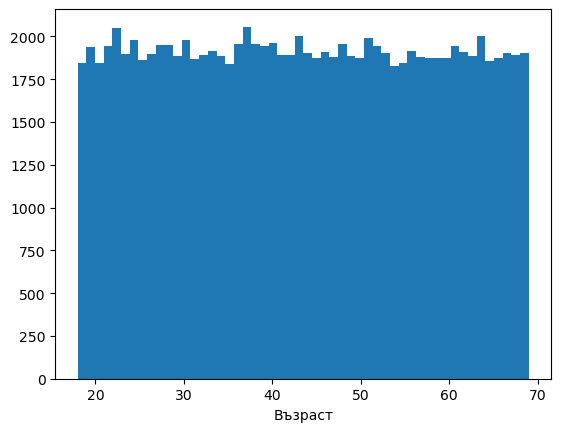

In [14]:
plt.hist(shopping["age"], bins=len(unique_ages))
plt.xlabel("Възраст")
plt.show()

Виждаме, че клиентите на въпросните молове са от всякакви възрасти и не преобладава само една възрастова група.

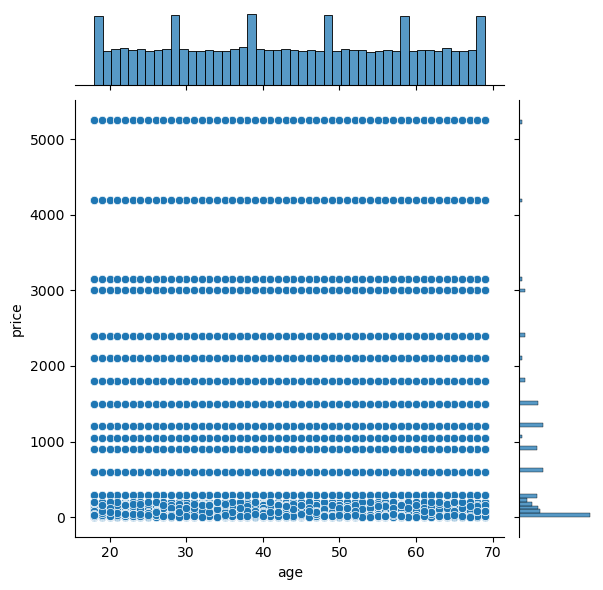

In [15]:
sns.jointplot(data=shopping, x="age", y="price");
# sns.displot(data=shopping, x="age");

Добавяме нова колона month_year, в която взимаме само месеца и годината от invoice_date, за да можем да разгледаме резултатите на месечна база.

In [16]:
shopping["month_year"] = shopping["invoice_date"].dt.strftime("%Y-%m")
shopping.head()

,gender,age,category,price,payment_method,invoice_date,shopping_mall,age_group,month_year
0,Female,28,Clothing,1500.40,Credit Card,2022-08-05,Kanyon,18-30,2022-08
1,Female,53,Books,60.60,Cash,2021-10-24,Kanyon,44-56,2021-10
2,Female,60,Clothing,600.16,Credit Card,2021-08-22,Kanyon,57-69,2021-08
3,Female,67,Clothing,600.16,Credit Card,2022-06-03,Kanyon,57-69,2022-06
4,Male,44,Technology,5250.00,Cash,2021-10-26,Kanyon,44-56,2021-10


Разглеждаме наличните платежни методи

In [17]:
unique_payment_methods = shopping['payment_method'].unique()
print(unique_payment_methods)

['Credit Card' 'Cash' 'Debit Card']


Тъй като искаме да сравняваме кешово плащане и плащане с карта, а имаме два вида плащане с карта 'Credit Card' и 'Debit Card' ще заменим двата метода само с 'Card', за да можем да ги разглеждаме заедно.

In [18]:
shopping['payment_method'] = shopping['payment_method'].replace(['Credit Card', 'Debit Card'], 'Card')

print(shopping['payment_method'].unique())

['Card' 'Cash']


In [19]:
shopping.head()

,gender,age,category,price,payment_method,invoice_date,shopping_mall,age_group,month_year
0,Female,28,Clothing,1500.40,Card,2022-08-05,Kanyon,18-30,2022-08
1,Female,53,Books,60.60,Cash,2021-10-24,Kanyon,44-56,2021-10
2,Female,60,Clothing,600.16,Card,2021-08-22,Kanyon,57-69,2021-08
3,Female,67,Clothing,600.16,Card,2022-06-03,Kanyon,57-69,2022-06
4,Male,44,Technology,5250.00,Cash,2021-10-26,Kanyon,44-56,2021-10


In [20]:
def group_and_sum(group_column):
    grouped_data = shopping.groupby([group_column, 'payment_method'])['price'].sum().unstack().reset_index()
    return grouped_data
grouped_data = group_and_sum('shopping_mall')

In [21]:
def plot_percentage_by_group(group_column, figsize=(10, 4)):
    grouped_data.iloc[:, 1:] = grouped_data.iloc[:, 1:].div(grouped_data.iloc[:, 1:].sum(axis=1), axis=0) * 100
    plt.figure(figsize=figsize)
    for i, column in enumerate(grouped_data.columns[1:]):
        if i == 0:
            plt.barh(grouped_data[group_column], grouped_data[column], label=column, alpha=0.7)
        else:
            left = grouped_data.iloc[:, 1:i+1].sum(axis=1)
            plt.barh(grouped_data[group_column], grouped_data[column], left=left, label=column, alpha=0.7)
    for i, column in enumerate(grouped_data.columns[1:]):
        for j, value in enumerate(grouped_data[column]):
            plt.text(value / 2 + (grouped_data.iloc[:, 1:i+1].sum(axis=1))[j], j, f'{value:.2f}%', ha='center', va='center')

    plt.title('Percentage of Total Price by Payment Method and ' + group_column.replace('_', ' ').title())
    plt.xlabel('Percentage of Total Price')
    plt.ylabel(group_column.replace('_', ' ').title())
    plt.legend(title='Payment Method')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [22]:
grouped_data = group_and_sum('age_group')
grouped_data

payment_method,age_group,Card,Cash
0,18-30,9501044.48,7703109.31
1,31-43,9407207.91,7847740.05
2,44-56,9602514.66,7493534.32
3,57-69,9335567.88,7660647.30


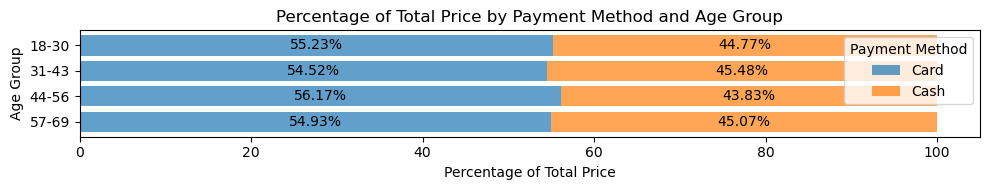

In [23]:
plot_percentage_by_group('age_group', figsize=(10, 2))

In [24]:
grouped_data = group_and_sum('shopping_mall')
grouped_data

payment_method,shopping_mall,Card,Cash
0,Cevahir AVM,1914348.46,1519323.38
1,Emaar Square Mall,1844232.06,1546176.25
2,Forum Istanbul,1906309.54,1429764.28
3,Istinye Park,3705068.72,3012008.82
4,Kanyon,7505533.57,6205221.67
5,Mall of Istanbul,7609958.06,6241779.56
6,Metrocity,5697197.68,4552782.39
7,Metropol AVM,3834673.50,3103319.49
8,Viaport Outlet,1868547.78,1545471.68
9,Zorlu Center,1960465.56,1549183.46


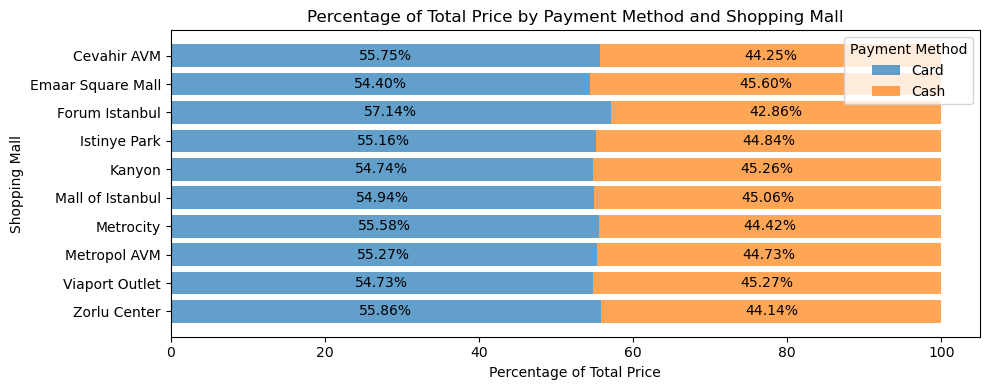

In [25]:
plot_percentage_by_group('shopping_mall', figsize=(10, 4))

In [26]:
grouped_data = group_and_sum('gender')
grouped_data

payment_method,gender,Card,Cash
0,Female,22526949.85,18404851.77
1,Male,15319385.08,12300179.21


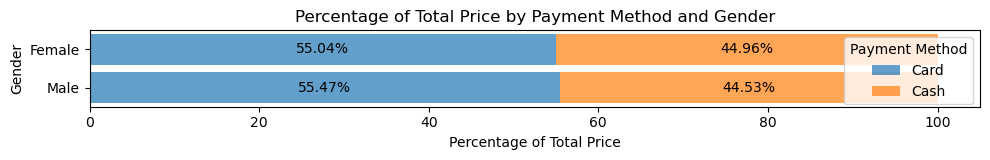

In [27]:
plot_percentage_by_group('gender', figsize=(10, 1.7))

In [28]:
grouped_data = group_and_sum('category')
grouped_data

payment_method,category,Card,Cash
0,Books,123487.65,103489.65
1,Clothing,17109361.28,13966323.36
2,Cosmetics,1038212.44,810394.46
3,Food & Beverage,128940.42,102628.29
4,Shoes,10037843.25,8097493.64
5,Souvenir,98356.05,76080.78
6,Technology,8716050.00,7056000.00
7,Toys,594083.84,492620.80


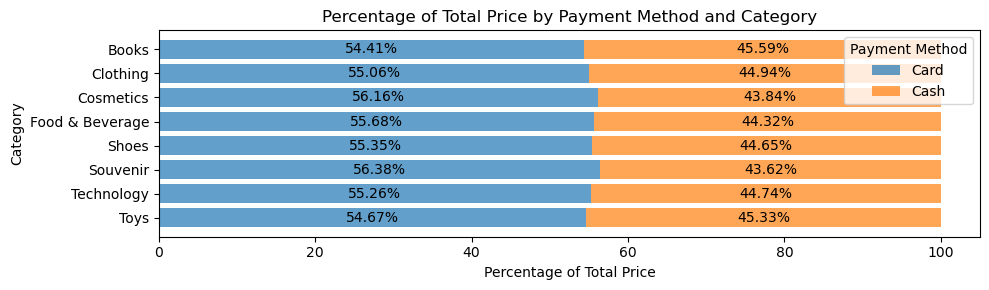

In [29]:
plot_percentage_by_group('category', figsize=(10, 3))

# Заключение
Наблюденията ни сочат, че за периода от разгледаните 27 месеца няма особена промяна в използването на кредитни/дебитни карти. Изглежда това е твърде кратък период за такава промяна.
Допускането, че възрастта указва влияние на използването на съвременни разплащателни средства също не е подтърдено от наблюдаваните данни

Изследването показва, че използването на гредитна/дебитна карта или кеш не се влияе от възраст, и пол, както и не се се променя дръстично с времето



# Източници

Dataset: 

[Customer Shopping Dataset - Retail Sales Data](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset)



Други изследвания с този дейтасет:

[Shopping data analysis and visualisation](https://www.kaggle.com/code/faraahanwaaar/shopping-data-analysis-and-visualisation )


[Customer shopping](https://www.kaggle.com/code/ilyai332/customer-shopping)


[Groupby tutorial](https://www.kaggle.com/code/ahmadihossein/groupby-tutorial)

